## Large Dataset: Integrated Surface Dataset (Global)

**Dataset source:** https://www.ncei.noaa.gov/metadata/geoportal/rest/metadata/item/gov.noaa.ncdc:C00532/html

**S3 URL:** The data are stored on S3 in the bucket s3://noaa-isd-pds/ as fixed width text files (https://noaa-isd-pds.s3.amazonaws.com/index.html).

**Dataset description:** The Integrated Surface Dataset (**ISD**) is composed of worldwide surface weather observations from over 35,000 stations, though the best spatial coverage is evident in North America, Europe, Australia, and parts of Asia. Parameters included are: air quality, atmospheric pressure, atmospheric temperature/dew point, atmospheric winds, clouds, precipitation, ocean waves, tides and more. ISD refers to the data contained within the digital database as well as the format in which the hourly, synoptic (3-hourly), and daily weather observations are stored. The format conforms to Federal Information Processing Standards (FIPS). ISD provides hourly data that can be used in a wide range of climatological applications. For some stations, data may go as far back as 1901, though most data show a substantial increase in volume in the 1940s and again in the early 1970s. Currently, there are over 14,000 "active" stations updated daily in the database.

**Dataset Identifiers:** NCEI DSI 3505_03 

--------------------------------------------------------
--------------------------------------------------------

## Small Dataset: Integrated Surface Data - “Lite”
**Dataset description:** The ISD-Lite data contain a fixed-width formatted subset of the complete Integrated Surface Data (ISD) for a select number of observational elements. The data are typically stored in a single file corresponding to the ISD data, i.e. one file per station per year. 

ISD-Lite contains eight common hourly time-series climatological variables represented in a fixed-width format. The elements extracted are:
1. Air temperature (degrees Celsius * 10)
2. Dew point temperature (degrees Celsius * 10)
3. Sea level pressure (hectopascals)
4. Wind direction (angular degrees)
5. Wind speed (meters per second * 10)
6. Total cloud cover (coded, see format documentation)
7. One-hour accumulated liquid precipitation (millimeters)
8. Six-hour accumulated liquid precipitation (millimeters)
The ISD-Lite data are represented with a modified time stamp which corresponds to the nearest hour of actual observation. Sub-hourly observations were removed. Duplicate observations were resolved according to a ranking system.

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



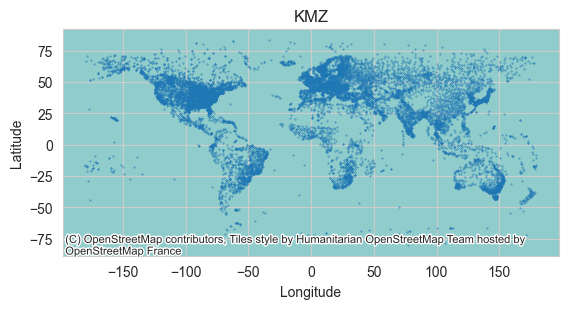

In [1]:
'''STEP.1: Global Weather Stations Visualization'''
import zipfile
import os
from xml.dom import minidom
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt

def read_kmz_file(kmz_filepath):
    # Temporary directory to store the extracted KML file
    temp_dir = "temp_kml"
    with zipfile.ZipFile(kmz_filepath, 'r') as kmz:
        kmz.extractall(temp_dir)

    # Find the extracted KML file
    kml_file = None
    for root, dirs, files in os.walk(temp_dir):
        for file in files:
            if file.endswith('.kml'):
                kml_file = os.path.join(root, file)
                break

    if kml_file is None:
        raise ValueError("No KML file found in KMZ archive.")

    # Read the KML file and return its content
    with open(kml_file, 'r') as f:
        kml_content = f.read()
    return kml_content


def extract_coordinates(kml_content):
    # Parse the KML file content using the minidom parser
    dom = minidom.parseString(kml_content)

    # Extract coordinate data
    coordinates = []
    for placemark in dom.getElementsByTagName('Placemark'):
        for coord in placemark.getElementsByTagName('coordinates'):
            coord_string = coord.firstChild.nodeValue
            coord_list = coord_string.split(',')
            longitude, latitude = map(float, coord_list[:2])
            coordinates.append((longitude, latitude))
    return coordinates


def visualize_coordinates(coordinates):
    # Create an empty GeoDataFrame
    gdf = gpd.GeoDataFrame(geometry=gpd.points_from_xy([coord[0] for coord in coordinates], [coord[1] for coord in coordinates]))
    # Plot the GeoDataFrame
    ax = gdf.plot(markersize=0.1)
    # Add a background map
    ctx.add_basemap(ax, zoom=12)
    # Set the plot
    ax.set_title('KMZ')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    # Show the plot
    plt.show()


# Path of the KMZ file
kmz_filepath = '/Users/a1234/Desktop/workspace/777/GDAL/data/isd.kmz'

# Read the KMZ file and extract data
kml_content = read_kmz_file(kmz_filepath)
print(f"Finished reading {len(kml_content)} KML files")
print(kml_content)  # Print the KML file content

# Save the kml_content variable as a txt file
txt_filepath = 'kml_content.txt'  # Replace with the desired path to save the txt file

with open(txt_filepath, 'w') as f:
    f.write(kml_content)

print(f"KML content saved as txt file: {txt_filepath}")

# Extract coordinate data
coordinates = extract_coordinates(kml_content)
#print(coordinates)

# Visualize coordinate data
visualize_coordinates(coordinates)


In [2]:
'''STEP.2: Country and Area Codes in the Dataset'''
# Specify the path to your file
file_path = '/Users/a1234/Desktop/workspace/UAV3.0/GDAL/noaa/country-list.txt'

# Open the file and read its contents
with open(file_path, 'r') as file:
    content = file.read()

# Print the content
print(content)

FIPS ID     COUNTRY NAME

AA          ARUBA                                                                           
AC          ANTIGUA AND BARBUDA                                                             
AF          AFGHANISTAN                                                                     
AG          ALGERIA                                                                         
AI          ASCENSION ISLAND                                                                
AJ          AZERBAIJAN                                                                      
AL          ALBANIA                                                                         
AM          ARMENIA                                                                         
AN          ANDORRA                                                                         
AO          ANGOLA                                                                          
AQ          AMERICAN SAMOA                  

Stations information data download:https://www.ncei.noaa.gov/maps/alltimes/

In [3]:
'''STEP.3: Acquisition and Formatting of Small DataSet'''
import os
import csv
import gzip
import json
from ftplib import FTP

def read_station_ids(file_path):
    with open(file_path, 'r') as f:
        reader = csv.reader(f)
        next(reader)  # Skip header
        station_ids = [row[0] for row in reader]
        station_ids = [id[:6] for id in station_ids]
        print(station_ids)
        return station_ids

def download_isd_lite_data(ftp, station_id, year, output_dir):
    file_name = f'{station_id}-99999-{year}.gz'
    remote_path = f'/pub/data/noaa/isd-lite/{year}/{file_name}'
    local_path = os.path.join(output_dir, file_name)

    try:
        with open(local_path, 'wb') as f:
            ftp.retrbinary(f'RETR {remote_path}', f.write)

        if os.path.getsize(local_path) == 0:
            print(f"No data available for {file_name}")
            os.remove(local_path)
        else:
            print(f'Downloaded {file_name}')
            # Convert to JSON and save to the json directory
            json_dir = os.path.join(output_dir, 'json')  # Path to JSON directory
            convert_gz_to_json(local_path, json_dir)
    except Exception as e:
        print(f'Error downloading {file_name}: {e}')


def convert_gz_to_json(gz_path, json_dir):
    # Ensure JSON directory exists
    if not os.path.exists(json_dir):
        os.makedirs(json_dir)

    # Build the path to the JSON file
    json_filename = os.path.splitext(os.path.basename(gz_path))[0] + '.json'
    json_path = os.path.join(json_dir, json_filename)

    # Read the .gz file and convert the content to JSON format
    with gzip.open(gz_path, 'rt') as gz_file:  # 'rt' mode means reading text data
        data = gz_file.read()  # Assuming the file content can be loaded into memory at once
        json_data = parse_gz_data_to_json(data)  # Parsing function

        # Save JSON data to a file
        with open(json_path, 'w') as json_file:
            json.dump(json_data, json_file, indent=4)

    print(f'Converted {os.path.basename(gz_path)} to JSON and stored in {json_dir}')


def parse_gz_data_to_json(data):
    json_data = []
    lines = data.splitlines()
    for line in lines:
        values = line.split()
        if len(values) == 12:  # Ensure each line of data has 12 values
            entry = {
                "Year": int(values[0]),
                "Month": int(values[1]),
                "Day": int(values[2]),
                "Hour": int(values[3]),
                "Temperature": int(values[4]),
                "Td": int(values[5]),
                "Pressure": int(values[6]),
                "WindDirection": int(values[7]),
                "WindSpeed": int(values[8]),
                "CloudCover": int(values[9]),
                "Rain1h": int(values[10]),
                "Rain6h": int(values[11]),
            }
            json_data.append(entry)
    return json_data


def download_contry_isd_lite_data(stations_file, start_year, end_year, output_dir):
    ftp = FTP('ftp.ncdc.noaa.gov')
    ftp.login()

    station_ids = read_station_ids(stations_file)

    for station_id in station_ids:
        for year in range(start_year, end_year + 1):
            download_isd_lite_data(ftp, station_id, year, output_dir)

    ftp.quit()

def combine_json_files(json_dir, combined_json_dir):
    os.makedirs(combined_json_dir, exist_ok=True)

    json_files = [f for f in os.listdir(json_dir) if f.endswith('.json')]

    # Group files and sort them according to rules
    file_groups = {}
    for json_file in json_files:
        prefix = '-'.join(json_file.split('-')[:2])
        if prefix not in file_groups:
            file_groups[prefix] = []
        file_groups[prefix].append(json_file)

    # Sort files by year and combine
    for prefix, files in file_groups.items():
        sorted_files = sorted(files, key=lambda x: int(x.split('-')[2].split('.')[0]))

        combined_data = []
        for file_name in sorted_files:
            with open(os.path.join(json_dir, file_name), 'r') as f:
                data = json.load(f)
                combined_data.extend(data)

        start_year1 = sorted_files[0].split('-')[2].split('.')[0]
        end_year1 = sorted_files[-1].split('-')[2].split('.')[0]

        combined_file_name = f"{prefix}-{start_year1}-{end_year1}.json"
        with open(os.path.join(combined_json_dir, combined_file_name), 'w') as f:
            json.dump(combined_data, f, indent=4)

        print(f"Combined files into {combined_file_name}")

if __name__ == '__main__':
    stations_file = 'jp.csv'
    # US：United States
    # JP：Japan
    # CN：China
    # CA：Canada
    # UK：United Kingdom
    # VM: Vietnam
    # SN: Singapore 
    # Massachusetts: Massachusetts in US
    start_year = 2014
    end_year = 2024
    base_directory = '/Users/a1234/Desktop/workspace/777/GDAL/noaa_data'
    folder_name = f"{start_year}_{end_year}_{os.path.splitext(stations_file)[0]}"
    folder_path = os.path.join(base_directory, folder_name)

    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    output_dir = folder_path

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    download_contry_isd_lite_data(stations_file, start_year, end_year, output_dir)

    # file path to combine JSON
    combined_json_dir = os.path.join(output_dir, 'conjson')
    # combine JSON
    combine_json_files(os.path.join(output_dir, 'json'), combined_json_dir)

    print('------------------Download Over-----------------')

['474090', '476680', '477300', '475450', '475820', '478230', '476741', '475750', '475420', '474760', '474770', '474070', '478030', '478210', '695314', '476794', '476790', '476790', '999999', '476820', '476410', '474340', '476830', '691464', '473120', '474280', '477210', '476390', '478440', '478430', '476160', '477060', '478080', '478070', '478060', '475950', '475570', '475954', '477670', '472130', '476060', '999999', '999999', '476340', '476320', '475810', '475150', '477540', '473080', '474880', '474300', '474320', '477550', '476540', '476810', '999999', '479350', '696064', '475490', '477610', '477690', '474400', '472310', '477890', '477650', '477920', '477895', '478140', '478240', '477880', '477150', '477510', '476713', '479995', '472590', '476370', '478090', '472900', '473530', '476660', '999999', '476430', '472050', '475920', '999999', '999999', '477640', '477641', '477830', '474130', '477900', '479310', '479310', '999999', '749331', '749330', '478510', '476280', '476050', '478500',